# Barcode and small chunk alignments

#### Prerequisites
This notebook will start up a dorado server, basecall and align or demultiplex the data and summarise it.
The summary steps are removed from the basecalling steps and the data to be summarised are included in the repository.
The base-calling step has been included for reproducibility and future proofing.
It will basecall using the sup,hac and fast models, so a sufficiently powerful GPU is required.

In order to not basecall, do not run the cells that contain the code snippet
```python
    with start_guppy_server_and_client(
        BIN_PATH, config, server_args = ["--data_path", f"{DOWNLOAD_DIRECTORY}/data/", "--num_dorado_worker_threads", "8"], client_args={"barcode_kits": "SQK-RBK114-96"}
    ) as client:
```

To basecall a working install of `dorado_basecall_server` must be local.
This can be fetched from https://cdn.oxfordnanoportal.com/software/analysis/ont-dorado-server_7.3.9_linux64.tar.gz

Example:

```bash
curl -LJO https://cdn.oxfordnanoportal.com/software/analysis/ont-dorado-server_7.3.9_linux64.tar.gz
tar -xzvf ont-dorado-server_7.3.9_linux64.tar.gz
```

Then set the `DOWNLOAD_DIRECTORY` variable to the path where the extracted directory is, which can be gotten from the command line like so:

```bash
realpath ont-dorado-server
```

#### Basecalling and Alignment
**Chunking** is done in the `chunking_code` directory. 2 .pod5 files have been included in the repository, these were the ones used in the paper.
They are both R10.4.1 5Khz.

- FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5 is from a Gridion run, and contains reads from Barcode75, using kit SQK-RBK114-96
- PAK77992_pass_57526a09_09d9a1d7_5.pod5 is from a promethion NA12878 ultra long run, and is not barcoded

They were chunked using the following command, where `--output-folder` is changed for the barcoded run or non barcoded run.
```bash
python chunking.py --input-folder  original_pod5s/barcoded/ --output-folder barcoded/ 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 6000 7000 8000 9000 10000
```

This will write out truncated pod5s into a folder format representing the lenght of the truncated signal.

**Alignment** requires a human reference, we used HG38.p14 with any alternative and unplaced contigs removed, so only the major 23 chromosome contigs were present.
The path to this can be updated via the `ALIGN_REF` variable in the cell below the _Actually base call and align_ header.

**Barcoding** is done seperate to the alignment as a suitable .pod5 for both did not exist. 

#### Summaries
These are created using pandas and some maths.
They generate precision, recall and F1 scores for the alignments, where a true positive is an alignment within 100 bases of the sup model basecalls for the full read, and for barcoding is the same barcode call as the sup model full read.

In [23]:
import lzma
import time
from contextlib import contextmanager, redirect_stdout
from io import StringIO
from pathlib import Path
import pod5
import re
from collections import defaultdict
from natsort import natsorted

from alive_progress import alive_bar
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from pybasecall_client_lib import helper_functions
from pybasecall_client_lib.helper_functions import (
    basecall_with_pybasecall_client,
    run_server,
    package_read
)
from pybasecall_client_lib.pyclient import PyBasecallClient
from readpaf import parse_paf

In [2]:
plt.style.use("../figures.mplstyle")
# Global bariables
DOWNLOAD_DIRECTORY = "/data/projects/rory_says_hi/ont-dorado-server/"
BIN_PATH = f"{DOWNLOAD_DIRECTORY}/bin"

## Basecall and align the pod 5 files

In [3]:
import operator
def get_item(obj, key, default="*"):
    if len(key) == 2:
        key, default = key
    
    try:
        r =  operator.getitem(obj, key)
        if key in {"genome", "direction"}:
            r = r.decode()
        return r
    except (IndexError, KeyError, TypeError, ValueError):
        return default

def read_to_paf(read: dict) -> str:
    """
    Create a PAF format string from a read dictionary returned from Pybasecall Client, 
    yielding PAF strings for all NONE secondary alignments (Secondary included)
    """
    if not read:
        raise RuntimeError("Issue with read, no data in dict")
    read_id = read["metadata"]["read_id"]
    query_sequence_length = read["metadata"]["sequence_length"]
    paf_keys = [
        "strand_start",
        "strand_end",
        "direction",
        "genome",
        ("genome_length", 0),
        "genome_start",
        "genome_end",
        "num_aligned",
        ("alignment_block_length", "*"),
        "mapping_quality"
    ]
    for al in filter(lambda x: not x["secondary_alignment"], read["datasets"]["align_results"]):
        paf_data = "\t".join((str(get_item(al, key)) for key in paf_keys))
        yield f"{read_id}\t{query_sequence_length}\t{paf_data}"


def read_to_summary(read: dict, summary_keys: list[str]) -> str:
    """
    Create a summary of the barcoded read call, containg all the columns used for analysis in this notebook.
    Returns a tab seperated string for each read.
    Columns are passed in as the summary_keys parameter.
    Fields written out:
        "read_id",
        "barcode_arrangement",
        "barcode_front_id",
        "barcode_rear_id",
        "barcode_front_foundseq",
        "barcode_rear_foundseq",
    """
    if not read:
        raise RuntimeError("Issue with read, no data in dict")
    return "\t".join((str(get_item(read["metadata"], key)) for key in summary_keys))


def safe_divide(a, b):
    """
    Safe divide two numbers, catches cases where all barcodes are 0
    """
    try:
        return a / b
    except ZeroDivisionError:
        return 0

In [4]:
@contextmanager
def start_guppy_server_and_client(
    bin_path: str,
    config: str,
    address: str = "ipc:///tmp/.guppy/5556",
    server_args: list[str] = [],
    client_args: dict[str:str] = {},
) -> None:
    server_args.extend(
        [
            "--config",
            config,
            "--port",
            address,
            "--log_path",
            str((Path(".") / "junk")),
            "--device",
            "cuda:all",
            "--disable_pings"
        ]
    )
    # This function has it's own prints that may want to be suppressed
    with redirect_stdout(StringIO()) as fh:
        server, port = run_server(server_args, bin_path=bin_path)
    print("started server")
    if port == "ERROR":
        raise RuntimeError("Server couldn't be started")

    if address.startswith("ipc"):
        address = f"{port}"
    else:
        address = f"localhost:{port}"
    client = PyBasecallClient(address=address, config=config, **client_args)
    client.connect()

    try:
        with client:
            yield client
    finally:
        print("Rip server")
        server.terminate()

def basecall_pod5(pod5_file: str | Path, client: PyBasecallClient) -> list[dict]:
    """
        Use the given pybasecall client instance to basecall all the reads in the given Pod5 file, and 
        return a list of the called reads, once they have all been receieved
    """
    completed_reads = []
    # time.sleep(10)
    reads_sent, reads_recv = 0,0
    with pod5.Reader(pod5_file) as pod5_reader:
        for read in pod5_reader.reads():
            t0 = time.time()

            success_pass = False
            while not success_pass:
                success_pass = client.pass_read(package_read(
                    read_id=str(read.read_id),
                    raw_data=read.signal,
                    daq_offset=float(read.calibration.offset),
                    daq_scaling=float(read.calibration.scale),
                    sampling_rate=float(5000),
                    start_time=int(read.start_sample)
                ))                        
            reads_sent += 1
            sleep_time = 0.4 - t0
            if sleep_time > 0:
                time.sleep(sleep_time)
    time.sleep(3)
    while reads_recv < reads_sent:
        print(reads_recv, reads_sent)
        results = client.get_completed_reads()
        # TODO: incorporate time_received into logging?
        # time_received = time.time()
        print(len(results))

        if not results:
            time.sleep(1)
            continue
        for res_batch in results:
            for res in res_batch:
                completed_reads.append(res)
                reads_recv += 1
    print(f"Received {reads_recv} back from caller")
    return completed_reads

#### Actually base call and align


In [5]:
search_dir = Path("chunking_code/non_barcoded/")
PAF_OUTPUT = Path("pafs/")
ALIGN_REF = "/data/refs//hg38.p14.simple.fa"
configs = ["dna_r10.4.1_e8.2_400bps_5khz_fast_prom.cfg", "dna_r10.4.1_e8.2_400bps_5khz_hac_prom.cfg", "dna_r10.4.1_e8.2_400bps_5khz_sup.cfg"]
# configs = [ "dna_r10.4.1_e8.2_400bps_5khz_fast.cfg"] # For development
for config in configs:
    print(f"basecalling with config {config}")
    pattern = r'(hac|sup|fast)'
    model = re.search(pattern, config).group(0)
    with start_guppy_server_and_client(
        BIN_PATH, config, server_args = ["--data_path", f"{DOWNLOAD_DIRECTORY}/data/", "--num_alignment_threads", "16", "--num_dorado_worker_threads", "8"], client_args={"align_ref": ALIGN_REF}
    ) as client:
        for pod5_file in search_dir.glob("*/*.pod5"):
            signal_length = str(pod5_file.parent.name).split("_")[0]
            paf_records = []
            print(pod5_file)
            completed_reads = basecall_pod5(pod5_file, client)
            for read in completed_reads:
                paf_records.extend([paf for paf in read_to_paf(read)])
            print(f"Writing {len(paf_records)} paf records")
            with open(f"{PAF_OUTPUT}/{signal_length}_{model}.paf", "w") as paf_fh:
                paf_fh.write("\n".join(paf_records))
            print("wrote file")                

basecalling with config dna_r10.4.1_e8.2_400bps_5khz_fast_prom.cfg
started server
chunking_code/non_barcoded/3000_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4000 paf records
wrote file
chunking_code/non_barcoded/4000_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4001 paf records
wrote file
chunking_code/non_barcoded/2500_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4001 paf records
wrote file
chunking_code/non_barcoded/7000_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4004 paf records
wrote file
chunking_code/non_barcoded/8000_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4011 paf records
wrote file
chunking_code/non_barcoded/2000_multi/PAK77992_pass_57526a09_09d9a1d7_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4001 paf r

## Basecall and demultiplex the barcoded run


In [6]:
configs = ["dna_r10.4.1_e8.2_400bps_5khz_fast.cfg", "dna_r10.4.1_e8.2_400bps_5khz_hac.cfg", "dna_r10.4.1_e8.2_400bps_5khz_sup.cfg"]
BARCODED_SUMMARYS = "barcoded_summaries"
search_dir_barcoded = Path("chunking_code/barcoded/")

summary_keys = [
    "read_id",
    "barcode_arrangement",
    "barcode_front_id",
    "barcode_rear_id",
    "barcode_front_foundseq",
    "barcode_rear_foundseq",
]
for config in configs:
    print(f"basecalling with config {config}")
    pattern = r'(hac|sup|fast)'
    model = re.search(pattern, config).group(0)
    with start_guppy_server_and_client(
        BIN_PATH, config, server_args = ["--data_path", f"{DOWNLOAD_DIRECTORY}/data/", "--num_dorado_worker_threads", "8"], client_args={"barcode_kits": "SQK-RBK114-96"}
    ) as client:
        for pod5_file in search_dir_barcoded.glob("*/*.pod5"):
            signal_length = str(pod5_file.parent.name).split("_")[0]
            summary_records = []
            print(pod5_file)
            completed_reads = basecall_pod5(pod5_file, client)
            for read in completed_reads:
                summary_records.append(read_to_summary(read, summary_keys))
            print(f"Writing {len(summary_records)} summary records to {BARCODED_SUMMARYS}/{signal_length}_{model}_summary.txt")
            with open(f"{BARCODED_SUMMARYS}/{signal_length}_{model}_summary.txt", "w") as summary_fh:
                headers = "\t".join(summary_keys)
                summary_fh.write(f"{headers}\n")
                summary_fh.write("\n".join(summary_records))
            print("wrote file")

basecalling with config dna_r10.4.1_e8.2_400bps_5khz_fast.cfg
started server
chunking_code/barcoded/3000_multi/FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4000 summary records to barcoded_summaries/3000_fast_summary.txt
wrote file
chunking_code/barcoded/4000_multi/FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4000 summary records to barcoded_summaries/4000_fast_summary.txt
wrote file
chunking_code/barcoded/2500_multi/FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4000 summary records to barcoded_summaries/2500_fast_summary.txt
wrote file
chunking_code/barcoded/7000_multi/FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5
0 4000
4000
Received 4000 back from caller
Writing 4000 summary records to barcoded_summaries/7000_fast_summary.txt
wrote file
chunking_code/barcoded/8000_multi/FAX05106_pass_barcode75_3b41bd57_90f4780b_5.pod5


### Read in "Truth" Paf file

In [7]:
truth_paf = "pafs/original_sup.paf"
with open(truth_paf, "rt") as fh:
    try:
        truth_paf_df = parse_paf(fh, dataframe=True)
    except Exception as e:
        print(f"Error reading in paf file - {repr(e)}")

truth_paf_df.drop_duplicates(["query_name"], keep="first", inplace=True)

truth_paf_df["map_start"] = np.where(
    truth_paf_df["strand"] == "+",
    truth_paf_df["target_start"],
    truth_paf_df["target_end"],
)

### Loop through the truncated PAF files

#### Calculate precision, recall, F1 for mappings within 100 base of original

In [8]:
result_dict = {}
path_to_paf_files = Path("pafs/")
paf_files = list(path_to_paf_files.rglob("*.paf"))
with alive_bar(len(paf_files), dual_line=True, title="Processing files") as bar:
    for comp_path in paf_files:
        with open(comp_path, "rt") as handle:
            try:
                comp_df = parse_paf(handle, dataframe=True)
            except FileNotFoundError as e:
                print(f"Error loading file {file} -> {repr(e)}")
                break
        comp_path = comp_path.name
        # lose multi mappings
        comp_df.drop_duplicates(["query_name"], keep="first", inplace=True)
        comp_df["map_start"] = pd.to_numeric(
            np.where(
                comp_df["strand"] == "+", comp_df["target_start"], comp_df["target_end"]
            )
        )
    
        result_all = truth_paf_df.merge(comp_df, on="query_name")
        result_all["same_strand"] = result_all["strand_x"] == result_all["strand_y"]
        result_all["ref_mapped"] = result_all.target_name_x != "*"
        result_all["query_mapped"] = result_all.target_name_y != "*"
        result_all["same_mapped"] = result_all.target_name_x == result_all.target_name_y
        for window in [100]:  # ,100,1000,5000,10000]:
            result_all["within_window"] = (
                abs(result_all.map_start_x.values - result_all.map_start_y.values) <= window
            )
    
            # True negatives will be:
            result_all["true_negative"] = result_all["target_name_x"].eq("*") & result_all[
                "target_name_y"
            ].eq("*")
            # False negatives will be:
            result_all["false_negative"] = result_all["target_name_x"].ne("*") & result_all[
                "target_name_y"
            ].eq("*")
    
            # True Positives
            result_all["true_positive"] = (
                result_all["same_mapped"]
                & result_all["target_name_x"].ne("*")
                & result_all["within_window"]
            )
    
            # False Positives
            result_all["false_positive"] = result_all["query_mapped"] & (
                (result_all.target_name_x != result_all.target_name_y)
                | (
                    abs(result_all.map_start_x.values - result_all.map_start_y.values)
                    > window
                )
            )
    
            comparison_dict = {}
            # loop through and get counts for each one to put into the dicitonary
            for result in [
                "true_positive",
                "false_positive",
                "true_negative",
                "false_negative",
            ]:
                comparison_dict[result] = (
                    result_all[result].value_counts().to_dict().get(True, 0)
                )
            comparison_dict["total"] = result_all.shape[0]
    
            # time for some precision
            try:
                precision = comparison_dict["true_positive"] / (
                    comparison_dict["true_positive"] + comparison_dict["false_positive"]
                )
            except ZeroDivisionError:
                precision = 0
            comparison_dict["precision"] = precision
    
            # time for some recall
    
            comparison_dict["recall"] = comparison_dict["true_positive"] / (
                comparison_dict["true_positive"] + comparison_dict["false_negative"]
            )
    
            try:
                F1 = (
                    2
                    * (comparison_dict["precision"] * comparison_dict["recall"])
                    / (comparison_dict["precision"] + comparison_dict["recall"])
                )
            except ZeroDivisionError:
                F1 = 0
            # time for some F1
            comparison_dict["F1"] = F1
    
            result_dict[(comp_path, window)] = comparison_dict
            bar()

Processing files |████████████████████████████████████████| 48/48 [100%] in 2.0s (23.92/s) 


In [9]:
f1_plot_df = (
    pd.DataFrame(result_dict)
    .T.reset_index()
    .rename(columns={"level_0": "filename", "level_1": "window_width"})
)
f1_plot_df[["read_length", "caller"]] = (
    f1_plot_df["filename"].str.split(pat="_", expand=True).loc[:, 0:1]
)
f1_plot_df["caller"] =f1_plot_df["caller"].str.split(".", expand=True).loc[:,0]

f1_plot_df["read_length"] = f1_plot_df["read_length"].str.replace(
    ".paf", "", regex=False
)

### Barcode F1 time

In [10]:
file = "barcoded_summaries/original_sup_summary.txt"

fields = [
    "read_id",
    "barcode_arrangement",
    "barcode_front_id",
    "barcode_rear_id",
    "barcode_front_foundseq",
    "barcode_rear_foundseq",
]

truth_seq_sum_df = pd.read_csv(file, usecols=fields, sep="\t")

In [11]:
barc_results = defaultdict(dict)
path_to_summary_files = Path("barcoded_summaries")
summary_files = list(path_to_summary_files.glob("*.txt"))
with alive_bar(len(summary_files), dual_line=True, title="Processing files") as bar:
    for comp_path in summary_files:
        length, model = comp_path.stem.split("_")[:2]
        bar.text = f'Analysing {comp_path.name}'
        fields = [
            "read_id",
            "barcode_arrangement",
            "barcode_front_id",
            "barcode_rear_id",
            "barcode_front_foundseq",
            "barcode_rear_foundseq",
        ]
        sup_seq_sum_df = pd.read_csv(comp_path, usecols=fields, sep="\t")
        barc_all = truth_seq_sum_df.merge(sup_seq_sum_df, on="read_id", how="left")
        barc_all["same"] = np.where(
            barc_all["barcode_arrangement_x"] == barc_all["barcode_arrangement_y"], 1, 0
        )
        tn = len(
            barc_all[
                barc_all["same"].eq(1)
                & barc_all["barcode_arrangement_x"].eq("unclassified")
            ]
        )
        tp = len(
            barc_all[
                barc_all["same"].eq(1)
                & ~barc_all["barcode_arrangement_x"].eq("unclassified")
            ]
        )
        fn = len(
            barc_all[
                ~barc_all["barcode_arrangement_x"].eq("unclassified")
                & barc_all["barcode_arrangement_y"].eq("unclassified")
            ]
        )
        fp = len(
            barc_all[
                barc_all["barcode_arrangement_x"].eq("unclassified")
                & ~barc_all["barcode_arrangement_y"].eq("unclassified")
            ]
        )
        # print (tn,tp,fn,fp)
        precision = safe_divide(tp, (tp + fp))
        recall = safe_divide(tp, (tp + fn))
        f1 = safe_divide(2 * (precision * recall), (precision + recall))
        # print (precision, recall, f1)
        barc_results[model][length] = {}
        barc_results[model][length]["precision"] = precision
        barc_results[model][length]["recall"] = recall
        barc_results[model][length]["f1"] = f1
        bar()

Processing files |████████████████████████████████████████| 48/48 [100%] in 0.8s (60.81/s) 


In [12]:
barcs = pd.concat({k: pd.DataFrame(v).T for k, v in barc_results.items()}, axis=0)
barcs.reset_index(inplace=True)
barcs = barcs.rename(columns={"level_0": "caller", "level_1": "length"})

In [20]:
natsorted(f1_plot_df["read_length"].unique())

['500',
 '1000',
 '1500',
 '2000',
 '2500',
 '3000',
 '3500',
 '4000',
 '4500',
 '5000',
 '6000',
 '7000',
 '8000',
 '9000',
 '10000',
 'original']

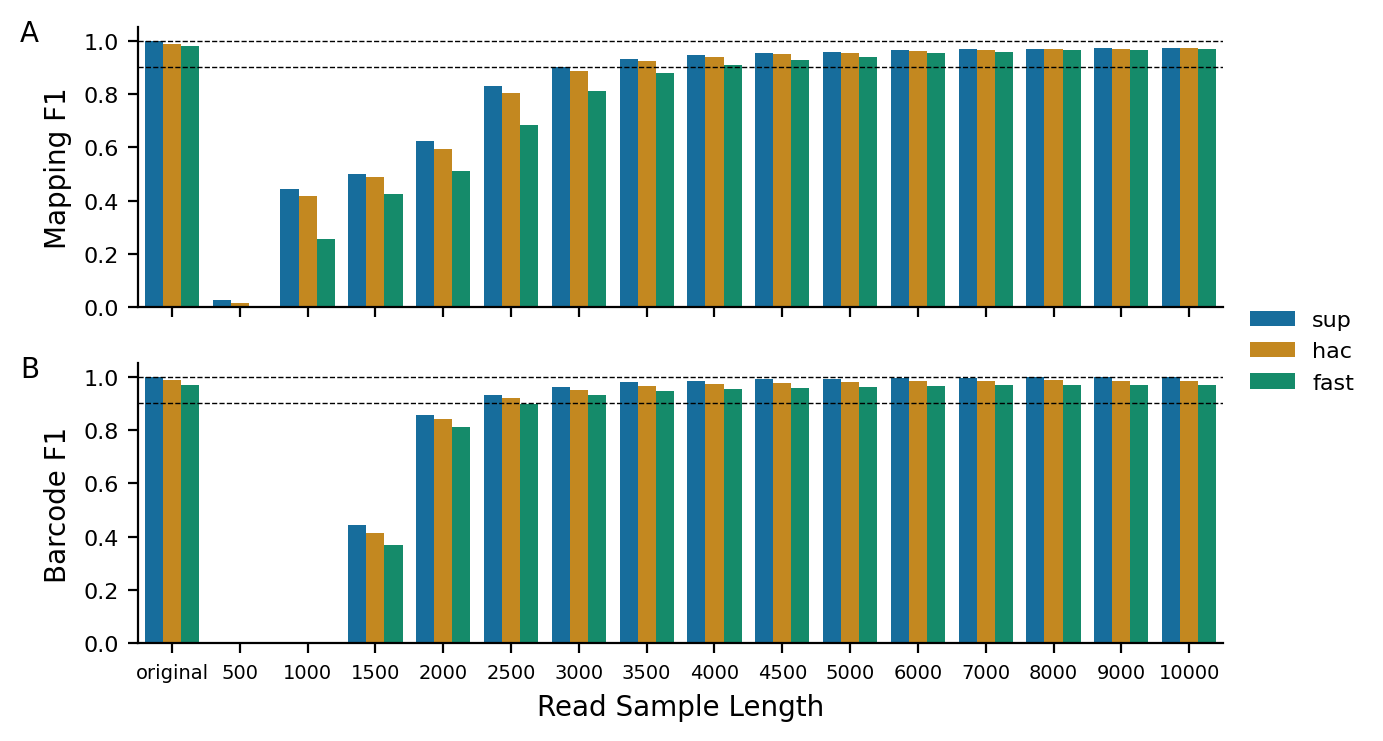

In [56]:
sample_list = ["sup", "hac", "fast"]

shared_kws = {
    "order": ["original"]
    + natsorted(f1_plot_df["read_length"].unique())[:-1],

    "palette": "colorblind",
}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 4), gridspec_kw={"hspace": 0.2}, sharex=True)
sns.barplot(
    ax=ax1,
    x="read_length",
    y="F1",
    hue="caller",
    # data=f1_plot_df[f1_plot_df['window_width'].eq(1000)],
    data=f1_plot_df,
    ci=None,
    hue_order=sample_list,
    **shared_kws,
)

ax1.set(ylabel="Mapping F1")
ax1.set(xlabel=None)
ax1.axhline(0.9, lw=0.5, ls="--", c="k")
ax1.axhline(1.0, lw=0.5, ls="--", c="k")
ax2.text(
    -0.1,
    0.98,
    "A",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax1.transAxes,
)
sns.move_legend(
    ax1,
    loc="upper right",
    bbox_to_anchor=(1.15, 0.5),
    fontsize=8,
    frameon=False,
    title=None,
)


# Plot Barcode
sns.barplot(
    ax=ax2,
    x="length",
    y="f1",
    hue="caller",
    data=barcs,
    hue_order=["sup", "hac", "fast"],
    **shared_kws,
)
ax2.axhline(0.9, lw=0.5, ls="--", c="k")
ax2.axhline(1.0, lw=0.5, ls="--", c="k")

ax2.set(ylabel="Barcode F1")
ax2.set(xlabel="Read Sample Length")
legend = ax2.get_legend()
if legend:
    legend.remove()
# sns.move_legend(
#     ax2,
#     loc="center right",
#     bbox_to_anchor=(1.135, 0.5),
#     fontsize=8,
#     frameon=False,
#     title=None,
# )

ax2.text(
    -0.1,
    0.98,
    "B",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax2.transAxes,
)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=7)
legend = ax1.get_legend()
if legend:
    legend.remove()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1., 0.475), borderaxespad=0., frameon=False, markerscale=0.8, fontsize=8)

fig.savefig("figure_1.pdf", bbox_inches="tight")